# Split into Train / Valid / Test set

## Load Dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


## Convert to PyTorch Tensor

### x, y Split

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


### Train / Valid / Test Random Split

In [6]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [7]:
train_cnt = int(data.size(0) * ratios[0]) # data.size(0) : data의 행의 갯수 즉, data의 전체 샘플 갯수
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt  # == int(data.size(0) * ratios[2])
cnts = [train_cnt, valid_cnt, test_cnt]  # cnts = [12384, 4128, 4128]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


In [8]:
# Shuffle before split.
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# Split train, valid and test set with each count.
x = list(x.split(cnts, dim=0))  # x.split(cnts, dim =0 ) 결과가 tuple로 나와서 list로 바꿔줌
y = y.split(cnts, dim=0)  # y는 튜플 형태로 쓰네??
# cnts = [12384, 4128, 4128] (리스트)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


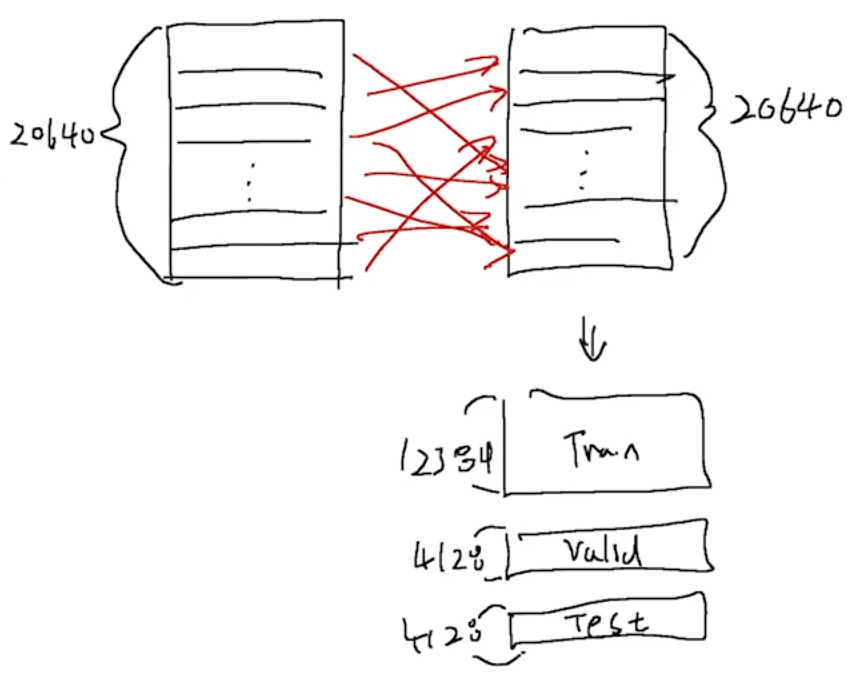

## Preprocessing

In [9]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # 매우 중요!!! You must fit with train data only.
                         # x[0]은 Train Data에 해당함
x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()  # Train Data의 x
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()  # Validation Data의 x
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()  # Test Data의 x
# 중요! Train Data에 대해 fit한 StandardScaler를 이용해 Train/Validation/Test Data의 x를 Scaling함

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,-1.337976,0.039268,0.938162,1.744210,-0.922676,-0.098696,-0.679357,1.758942
12380,0.181147,-2.096748,0.318691,0.063251,0.269824,-0.064301,0.553543,-0.145924
12381,0.116286,1.858838,-0.457874,0.380912,-0.949235,-0.076714,0.994198,-1.307793
12382,-0.021677,-0.593625,0.138888,-0.036659,-0.033834,-0.040006,-1.195020,1.245327
12383,-0.142738,1.225944,1.232146,0.992239,-0.648233,-0.240747,0.422282,-1.163182


**스케일링 할 때 주의**
- Train/Valid/Test를 먼저 Split한 다음, Train Data에 대해서만 fit해야 한다!!!
- 사람들이 자주 하는 실수: Train/Valid/Test를 나누지 않고 전체 데이터에 대해서 fit,transform하는 경우가 종종 있음

## Build Model & Optimizer

In [10]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
optimizer = optim.Adam(model.parameters())

## Train

In [12]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [13]:
from copy import deepcopy

lowest_loss = np.inf  # Loss는 값이 점점 작아져야 하니까 초기값은 +∞으로 설정
best_model = None

early_stop = 100   # 100 "epoch"s 동안 Validation Loss의 개선이 없으면 학습을 종료
lowest_epoch = np.inf

In [14]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0)) # x[0].size(0): x[0]의 첫 번째 차원의 크기. 여기서는 행 갯수
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)  # iteration들을 돌면서 각 iteration마다의 train_loss 누적

    train_loss = train_loss / len(x_) # 들여쓰기 주의!
                                      # 1 epoch가 마치면 해당 에포크 동안의 평균 train_loss 산출

    # You need to declare to PYTORCH to stop build the computation graph.
    with torch.no_grad(): # torch.no_grad() => validation set은 학습을 위한 것이 아니니까 gradient descent 하면 안 됨!
        # You don't need to shuffle the validation set. because, 학습을 위한 것이 아니니까!
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)  # 들여쓰기 주의!
    
    # Log each loss to plot after training is done. (1 epoch 마다 Train Loss와 Valid Loss 값을 각각 리스트에 저장)
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss: # 현재 에포크 i의 valid_loss가 lowest_loss보다 작다면 lowest_loss 값을 갱신
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 'state_dict()' returns model weights as key-value.
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())  # 현재 에포크까지 가장 낮은 Loss를 가진 Model을 Best Model로 저장
    else:   # valid_loss가 lowest_loss보다 큰 경우 이 else 블록 실행
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            # 1) early_stop > 0: early_stop이 0보다 크다면, 즉 "early_stop을 사용한다면"
            # 2) lowest_epoch + early_stop < i + 1: (가장 낮은 Loss에서의 epoch 수 + 얼리 스탑 에포크 수)가 (현재 에포크 수)보다 작다면
            
            print("There is no improvement during last %d epochs." % early_stop)
            break

            
# 모든 for문 마침            
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 100: train loss=3.4720e-01  valid_loss=3.3938e-01  lowest_loss=3.4056e-01
Epoch 200: train loss=3.0026e-01  valid_loss=2.9215e-01  lowest_loss=2.9067e-01
Epoch 300: train loss=2.9045e-01  valid_loss=2.8444e-01  lowest_loss=2.8279e-01
Epoch 400: train loss=2.8746e-01  valid_loss=2.8237e-01  lowest_loss=2.8207e-01
Epoch 500: train loss=2.8728e-01  valid_loss=2.8370e-01  lowest_loss=2.8160e-01
Epoch 600: train loss=2.8657e-01  valid_loss=2.8159e-01  lowest_loss=2.8090e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 539: 2.8090e-01


<All keys matched successfully>

## Loss History

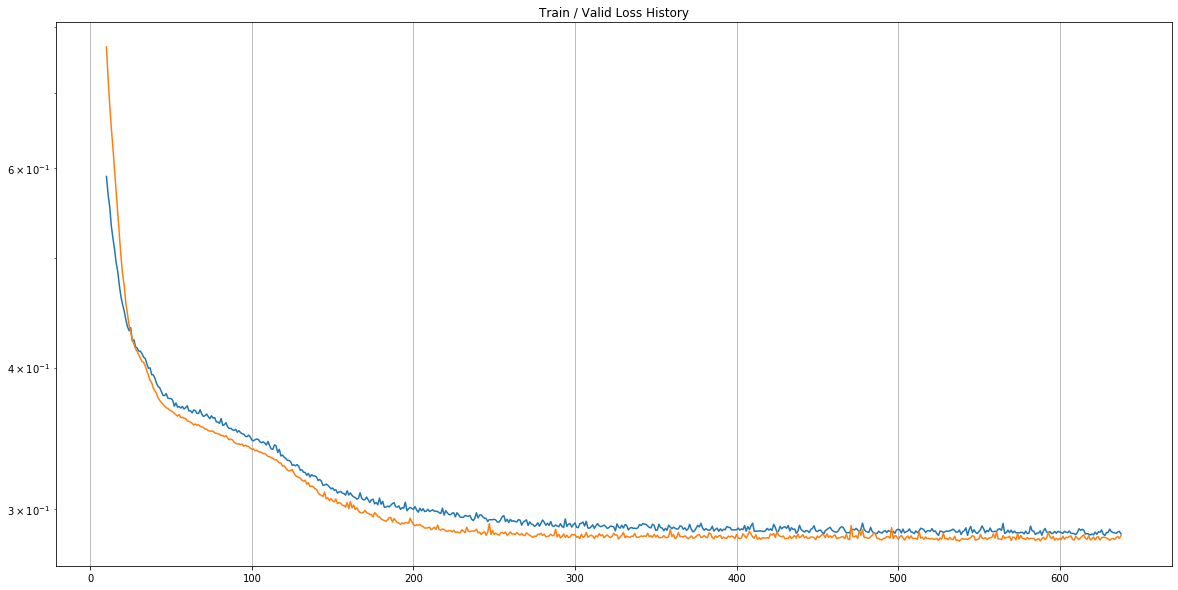

In [15]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [16]:
# Test Loss 산출
test_loss = 0
y_hat = []



with torch.no_grad(): # torch.no_grad() => Test set도 학습을 위한 것이 아니니까 gradient descent 하면 안 됨!
    # Test Set도 학습을 위한 것이 아니라서 shuffle 안해줘도 됨. Split만 하면 됨
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i) # y_hat 산출
        loss = F.mse_loss(y_hat_i, y_i)  # Loss 산출

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)  # Test 데이터의 평균 Loss 계산
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history),
                        key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
print("Valid loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 2.8728e-01
Valid loss: 2.8090e-01
Test loss: 2.9679e-01


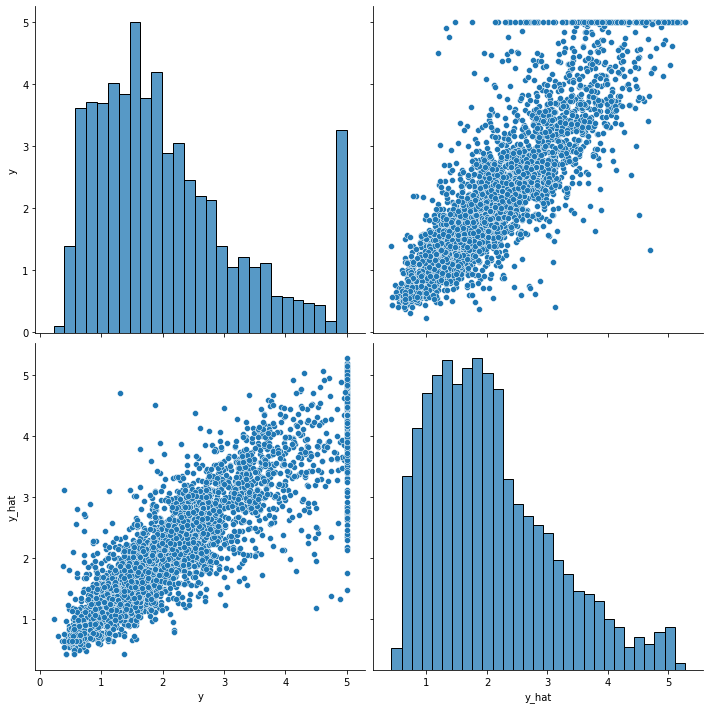

In [17]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()